In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [2]:
init_Seed()

No GPU!


In [3]:
class MLDataset(Dataset):
    """ Dataset for loading and preprocessing the MoviesLen dataset. """
    def __init__(self, path, mode='train', target_only=False):
        super().__init__()
        self.mode = mode

        # Read data into numpy arrays
        data = np.loadtxt(path, dtype='long')

        # Convert data into PyTorch tensors
        self.data = torch.LongTensor(data[:, :2])
        self.target = torch.FloatTensor(data[:, 2])

        print(f'Max user: {max(self.data[:, 0])}')
        print(f'Max item: {max(self.data[:, 1])}')

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of MoviesLen Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [4]:
class MF(nn.Module):
    def __init__(self, n_users=6050, m_items=4001, n_factors=50):
        super(MF, self).__init__()

        self.U = torch.nn.Parameter(torch.rand(n_users, n_factors, requires_grad=True))

        self.P = torch.rand(m_items, 500 * n_factors, requires_grad=False)
        # self.Q = torch.nn.Parameter(torch.rand(n_factors * 500, n_factors, requires_grad=True))

        
        self.net = nn.Sequential(nn.Linear(500 * n_factors, n_factors), nn.ReLU(), nn.Linear(n_factors, n_factors))


        self.U.data.uniform_(-0.005, 0.005)
        # self.Q.data.uniform_(-0.005, 0.005)
        # self.Q.weight.data.uniform_(-0.005, 0.005)
        
        self.criterion = nn.MSELoss(reduction='sum')
    
    def forward(self, user, item):
        # return torch.einsum('ij, ij -> i', [self.U[user], self.P[item] @ self.Q])
        return torch.einsum('ij, ij -> i', [self.U[user], self.net(self.P[item])])

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = MLDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Train/Dev/Test**

In [6]:
# U = torch.rand(size=(1005, 20), requires_grad=True)
# V = torch.rand(size=(2005, 20), requires_grad=True)
# with torch.no_grad():
#     U /= 100
#     V /= 100

## **Training**

In [7]:
# def model(X):
#     return torch.einsum('ij, ij -> i', [U[X[:, 0]], V[X[:, 1]]])

# def squared_loss(y_hat, y):  #@save
#     """Squared loss."""
#     return (y_hat - y.reshape(y_hat.shape))**2 / 2

# def objective(X, y):
#     return squared_loss(model(X), y).sum() + (U[X[:, 0]].norm() ** 2 + V[X[:, 1]].norm() ** 2) * 0.01

# def sgd(params, lr, batch_size):  #@save
#     """Minibatch stochastic gradient descent."""
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad
#             param.grad.zero_()

In [8]:
def train(tr_set, dv_set, model, config):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_size = config['batch_size']

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])
            mse_loss = model.cal_loss(y_hat, y)
            mse_loss.backward()
            
            optimizer.step()
            # scheduler.step()

            # loss_record['train'].append(mse_loss.detach().cpu().item())
            loss_record['train'].append(mse_loss.detach().cpu().item() / len(y))

            # print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item()))
            print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item() / len(y)))

        
        epoch += 1
        
        # print("train_loss: {:.4f}".format(np.mean(loss_record['train'][-100:])))

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            early_stop_cnt = 0
            print("Saving model (epoch = {:4d}  loss = {:.4f} )".format(epoch, dev_mse))
            torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        
        # if epoch > 10:
        #     break
        
        loss_record['dev'].append(dev_mse)

        if early_stop_cnt > config['early_stop']:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

## **Validation**

In [9]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for X, y in dv_set:                         # iterate through the dataloader
        X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        # total_loss += mse_loss.detach().cpu().item() * len(y)    # accumulate loss
        total_loss += mse_loss.detach().cpu().item()     # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [11]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False               

config = {
    'n_epochs': 500,              # maximum number of epochs
    'batch_size': 50000,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.002,                # learning rate
        # 'weight_decay': 0.001
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 2,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    'D': 50
}

# **Load data and model**

In [12]:
ML100K_train = '../data/ML100K/ML100K_copy1_train.txt'
ML100K_test = '../data/ML100K/ML100K_copy1_test.txt'

ML1M_train = '../data/ML1M/ML1M_copy1_train.txt'
ML1M_test = '../data/ML1M/ML1M_copy1_test.txt'

tr_set = prep_dataloader(ML1M_train, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(ML1M_test, 'dev', config['batch_size'], target_only=target_only)
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

Max user: 6040
Max item: 3952
Finished reading the train set of MoviesLen Dataset (600126 samples found, each dim = 2)
Max user: 6040
Max item: 3952
Finished reading the dev set of MoviesLen Dataset (200041 samples found, each dim = 2)


In [13]:
model = MF(n_factors=config['D']).to(device) 

# **Start Training!**

In [14]:
model.P[[4, 5]]

tensor([[0.8411, 0.8388, 0.1034,  ..., 0.9757, 0.9952, 0.6632],
        [0.2589, 0.7697, 0.9221,  ..., 0.8348, 0.4028, 0.7235]])

In [15]:
%%time
for _ in range(3):
    model_loss, model_loss_record = train(tr_set, dv_set, model, config)
    model.P = model.net(model.P).detach()
    model.net = nn.Sequential(nn.Linear(config['D'], config['D']), nn.ReLU(), nn.Linear(config['D'], config['D']))
    print("ending a era !!!")

# model_loss, model_loss_record = train(tr_set, dv_set, model, config)

train_loss: 14.0892
train_loss: 13.2886
train_loss: 10.6502
train_loss: 6.7880
train_loss: 2.7604
train_loss: 1.8675
train_loss: 4.5031
train_loss: 4.0138
train_loss: 2.1557
train_loss: 1.2275
train_loss: 1.5372
train_loss: 2.2928
train_loss: 2.3504
Saving model (epoch =    1  loss = 3.1935 )
train_loss: 3.1830
train_loss: 3.0743
train_loss: 2.5625
train_loss: 1.8791
train_loss: 1.3857
train_loss: 1.2821
train_loss: 1.5759
train_loss: 1.9360
train_loss: 1.8810
train_loss: 1.5362
train_loss: 1.2173
train_loss: 1.1588
train_loss: 1.3598
Saving model (epoch =    2  loss = 1.5786 )
train_loss: 1.5603
train_loss: 1.7473
train_loss: 1.7216
train_loss: 1.5668
train_loss: 1.3239
train_loss: 1.1647
train_loss: 1.1603
train_loss: 1.2798
train_loss: 1.3870
train_loss: 1.3599
train_loss: 1.2511
train_loss: 1.1517
train_loss: 0.8987
Saving model (epoch =    3  loss = 1.1970 )
train_loss: 1.1919
train_loss: 1.2446
train_loss: 1.2750
train_loss: 1.2587
train_loss: 1.1848
train_loss: 1.1305
train_loss

KeyboardInterrupt: 

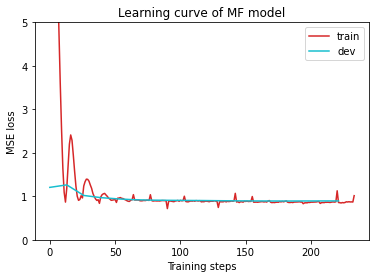

In [ ]:
plot_learning_curve(model_loss_record, title='MF model')

In [ ]:
model.P[[4, 5]]

tensor([[-2.9165, -1.9754,  1.2819,  0.4916, -0.6243, -1.6791, -1.8433,  1.9390,
          1.4802,  0.4703,  2.6781,  0.9486,  0.4722,  3.5658,  1.4404, -1.9505,
         -2.0593,  4.0978, -3.6472,  1.0234,  2.0114,  0.2622,  0.0080,  1.5198,
         -0.0478, -4.8525,  1.9800,  0.3002, -3.7249,  2.7980,  1.9389,  2.6786,
          0.5358,  0.0220, -3.2623,  0.1448, -1.0592, -0.1768, -1.3566, -2.2110,
          1.6566,  0.5033, -2.8388, -1.3900,  2.0297, -1.7225,  0.3378,  1.7175,
         -0.6980,  1.7874],
        [-2.9954, -2.0111,  1.2866,  0.4715, -0.5624, -1.7238, -1.9141,  1.9582,
          1.5393,  0.4330,  2.7365,  0.8847,  0.4822,  3.5500,  1.5148, -2.0043,
         -2.1654,  4.1591, -3.6351,  0.9251,  1.8608,  0.3956, -0.0586,  1.5382,
         -0.1240, -4.8824,  2.0207,  0.2949, -3.7359,  2.8684,  1.9909,  2.7929,
          0.5242,  0.0057, -3.2738,  0.0740, -1.0134, -0.1086, -1.2906, -2.2332,
          1.7014,  0.5198, -2.8282, -1.4672,  2.0472, -1.6796,  0.2569,  1.7593,


In [ ]:
np.sqrt(model_loss)

0.9442502968223242

In [ ]:
np.sqrt(model_loss_record['dev'][-1])

0.9454400886140776

In [ ]:
# del model
# model = MF().to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# dev(dv_set, model, device)

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
# def save_pred(preds, file):
#     ''' Save predictions to specified file '''
#     print('Saving results to {}'.format(file))
#     with open(file, 'w') as fp:
#         writer = csv.writer(fp)
#         writer.writerow(['id', 'tested_positive'])
#         for i, p in enumerate(preds):
#             writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)


In [ ]:
pp = torch.nn.Parameter(torch.rand(2, 3, requires_grad=True))
pp

Parameter containing:
tensor([[0.3980, 0.0727, 0.6101],
        [0.8071, 0.0478, 0.5004]], requires_grad=True)

In [ ]:
pp[0]

tensor([0.3980, 0.0727, 0.6101], grad_fn=<SelectBackward>)

In [ ]:
for X, y in dv_set:                         # iterate through the dataloader
    X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
        print(((pred -y) ** 2).mean())

# total_loss = total_loss / len(dv_set.dataset)   
    

tensor(12.3486)
tensor(12.5602)
tensor(12.3733)
tensor(12.7423)
tensor(12.7512)


In [ ]:
# U = torch.nn.Parameter(torch.rand(2, 3, requires_grad=True))
# P = torch.nn.Parameter(torch.rand(2, 6, requires_grad=False))
# net = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
# torch.einsum('ij, ij -> i', [U[[0, 1]], net(P[[0, 1]])])
# gg = torch.Tensor([0.3, 0.7])
# nn.Sigmoid()(gg)